# Tomograf


In [97]:
from ipywidgets import *
from PIL import Image
import numpy as np
from skimage.draw import line
from IPython.display import display

Tworzymy klasę odpowiadającą za przetwarzanie obrazu wejściowego na sinogram oraz późniejszą rekonstrukcję tego obrazu

In [98]:
class Tomograph:
    def __configure(self, img, *, alpha=1, n_detectors=1000, phi=np.pi, hamm_filter=True):
        self.img = img
        self.__reshape_img()
        self.img = np.asarray(self.img)
        self.alpha = alpha
        self.n_detectors = n_detectors
        self.phi = phi
        self.n_steps = int(np.floor(180 / self.alpha))
        self.generated_sinogram = np.zeros((self.n_steps, self.n_detectors), dtype=int)
        self.bresenham_lines = []
        self.hamm_filter = hamm_filter
        self.reconstructed = []

    def __reshape_img(self):
        width, height = self.img.size
        new_size = max(width, height)
        self.img = self.img.resize((new_size, new_size))

    def __map_coords(self, angle):
        width = int(self.img.shape[0] / 2)
        x = int(np.cos(angle) * width) + width - 1
        y = -int(np.sin(angle) * width) + width - 1
        return x, y

    def get_sinogram(self):
        return Image.fromarray(self.generated_sinogram).convert('L')

    def __normalize_img(self, img):
        brightest_pixel = np.max(img)
        if brightest_pixel == 0:
            return img
        return img / brightest_pixel * 255

    def __generate_sinogram(self):
        i = 0
        sl_filter = self.__hamming_filter(self.n_detectors)
        for angle in np.arange(0, np.pi, self.alpha * (np.pi / 180)):
            for detector in range(self.n_detectors):
                emitter_angle = angle + self.phi / 2 - detector * self.phi / (self.n_detectors - 1)
                emitter_coordX, emitter_coordY = self.__map_coords(emitter_angle)
                detector_angle = angle + np.pi - self.phi / 2 + detector * self.phi / (self.n_detectors - 1)
                detector_coordX, detector_coordY = self.__map_coords(detector_angle)

                rr, cc = line(emitter_coordX, emitter_coordY, detector_coordX, detector_coordY)
                self.generated_sinogram[i][detector] += self.img[rr, cc].sum()
                self.bresenham_lines.append([rr, cc])

            if self.hamm_filter:
                self.generated_sinogram[i] = np.array(np.convolve(self.generated_sinogram[i], sl_filter, 'same'))
            i += 1
            # print(i)

        self.generated_sinogram = self.__normalize_img(self.generated_sinogram)

    def reconstruct(self):
        reconstructed_img = np.zeros((self.img.shape[0], self.img.shape[1]))
        i = 0
        generated_sinogram_flattened = self.generated_sinogram.flatten()

        for bresenham_line in self.bresenham_lines:
            rr, cc = bresenham_line
            reconstructed_img[rr, cc] += generated_sinogram_flattened[i]
            i += 1
            if i % 100 == 0:
                self.reconstructed.append(reconstructed_img.copy())
                self.reconstructed[-1] = self.__normalize_img(self.reconstructed[-1])
                self.reconstructed[-1] = Image.fromarray(self.reconstructed[-1]).convert('L')
                # print(i)
        else:
            self.reconstructed.append(reconstructed_img.copy())
            self.reconstructed[-1] = self.__normalize_img(self.reconstructed[-1])
            self.reconstructed[-1] = Image.fromarray(self.reconstructed[-1]).convert('L')
            # print(i)

    def get_reconstructed(self, number):
        return self.reconstructed[number].resize((400, 400))
    
    def get_images_number(self):
        return len(self.reconstructed)-1

    # Ram-Lak with hamming filter
    def __hamming_filter(self, length):
        filter = []
        ham = np.hamming(length)
        length = int(length/2)
        for i, j in zip(range(-length, length), ham):
            if i % 2 != 0:
                val = ((-4/np.pi**2)/(i**2)) * j
                filter.append(val)
            else:
                filter.append(0)
        filter[int(length)] = 1

        return filter

    def rmse(self, img1, img2):
        return np.sqrt(np.mean((img1-img2)**2))
    
    def run(self, source, *, alpha=1, n_detectors=1000, phi=np.pi, hamm_filter=True):
        initial_img = Image.open(source).convert('L')
        self.__configure(initial_img, alpha=alpha, n_detectors=n_detectors, phi=phi, hamm_filter=hamm_filter)
        self.__generate_sinogram()
        path = 'Output/Sinogram/sinogram.jpg'
        self.get_sinogram().save(path)
        display(Image.open(path))
        self.reconstruct()
        # i=0
        # reconstructed_images = []
        # for img in self.reconstruct():
        #     path = 'Output/Reconstructed_Image/part' + str(i) + '.jpg'
        #     img.save(path)
        #     img1 = open(path, 'rb').read()
        #     wi1 = widgets.Image(value=img1, format='png')
        #     reconstructed_images.append(img)
        #     i += 1
        # display(widgets.HBox(reconstructed_images))


### Wprowadzanie parametrów tomografu:
-  SOURCE_IMAGE_PATH - lokalizacja obrazu wejściowego
-  ALPHA - przeskok pomiędzy kolejnymi kątami nachylenia tomografu w stopniach
-  N_DETECTORS - liczba detektorów użytych dla jednego kąta nachylenia tomografu
-  PHI - kąt pomiędzy początkowym i końcowym połorzeniam tomografu

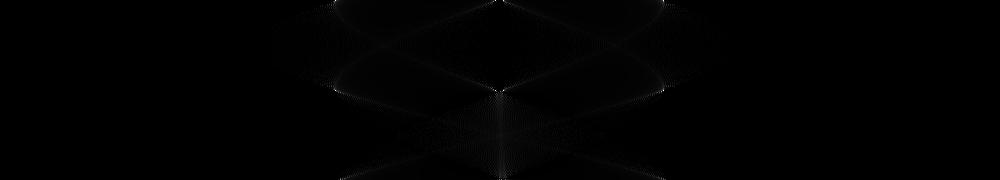

interactive(children=(IntSlider(value=0, description='number', max=1800), Output()), _dom_classes=('widget-int…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [99]:
# config
SOURCE_IMAGE_PATH = 'Input\Img\Shepp_logan.jpg'
ALPHA = 1
N_DETECTORS = 1000
PHI = np.pi
# config

tomograph = Tomograph()
tomograph.run(source=SOURCE_IMAGE_PATH, hamm_filter=True, alpha=ALPHA, n_detectors=N_DETECTORS, phi=PHI)
interact(tomograph.get_reconstructed, number=IntSlider(value=0, min=0, max=tomograph.get_images_number()))
